<a href="https://colab.research.google.com/github/center4ml/Workshops/blob/2023_2/Day_3/30_fighting_for_super-resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previous material

In [ ]:
import torch
import matplotlib.pyplot as plt

## FNO2d class

In [ ]:
"""

code adapted from from: https://github.com/khassibi/fourier-neural-operator/blob/main/fourier_2d.py


@original author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Darcy Flow discussed in Section 5.2 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

################################################################
# fourier layer
################################################################
class SpectralConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = torch.nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = torch.nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(torch.nn.Module):
    def __init__(self, modes1, modes2,  hidden_width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.hidden_width = hidden_width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = torch.nn.Linear(3, self.hidden_width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.hidden_width, self.hidden_width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.hidden_width, self.hidden_width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.hidden_width, self.hidden_width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.hidden_width, self.hidden_width, self.modes1, self.modes2)
        self.w0 = torch.nn.Conv2d(self.hidden_width, self.hidden_width, 1)
        self.w1 = torch.nn.Conv2d(self.hidden_width, self.hidden_width, 1)
        self.w2 = torch.nn.Conv2d(self.hidden_width, self.hidden_width, 1)
        self.w3 = torch.nn.Conv2d(self.hidden_width, self.hidden_width, 1)

        self.fc1 = torch.nn.Linear(self.hidden_width, 128)
        self.fc2 = torch.nn.Linear(128, 1)

    def forward(self, x):
        # x                       # Batch, Height, Width, 3
        x = self.fc0(x)           # Batch, Height, Width, H
        x = x.permute(0, 3, 1, 2) # Batch, H, Height, Width
        x = torch.nn.functional.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)        # Batch, H, Height, Width
        x2 = self.w0(x)           # Batch, H, Height, Width
        x = x1 + x2               # Batch, H, Height, Width
        x = torch.nn.functional.gelu(x)

        x1 = self.conv1(x)        # Batch, H, Height, Width
        x2 = self.w1(x)           # Batch, H, Height, Width
        x = x1 + x2               # Batch, H, Height, Width
        x = torch.nn.functional.gelu(x)

        x1 = self.conv2(x)        # Batch, H, Height, Width
        x2 = self.w2(x)           # Batch, H, Height, Width
        x = x1 + x2               # Batch, H, Height, Width
        x = torch.nn.functional.gelu(x)

        x1 = self.conv3(x)        # Batch, H, Height, Width
        x2 = self.w3(x)           # Batch, H, Height, Width
        x = x1 + x2               # Batch, H, Height, Width

        if self.padding > 0:
          x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1) # Batch, Height, Width, H
        x = self.fc1(x)           # Batch, Height, Width, 128
        x = torch.nn.functional.gelu(x)
        x = self.fc2(x)           # Batch, Height, Width, 1
        return x

## Reading Data

Unfortunately we'll need rather heavy artilery only to read input and ground truth output data. The exemplary one item of the input data we worked with earlier, was taken from that source, too. I *copied-and-pasted* it. So we avoided using packaged code for now.

Unfortunately, we can't continue that way, we can't copy-paste the whole dataset. The data will come from the `neuraloperator` package which is an official codebase from the Kovachki lab: [neuraloperator GitHub page](https://github.com/neuraloperator/neuraloperator).

In [ ]:
!pip install wandb
!pip install ruamel.yaml
!pip install configmypy
!pip install tensorly
!pip install tensorly-torch
!pip install torch-harmonics
!pip install matplotlib
!pip install opt-einsum
!pip install h5py
!pip install zarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 69.4 M

In [ ]:
!pip install neuraloperator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.0 MB/s eta 0:00:00


In [ ]:
from neuralop.datasets import load_darcy_flow_small

sdf_train_loader, sdf_test_loaders, sdf_output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)

train_samples_x = torch.permute(torch.stack([sdf_train_loader.dataset[i]['x'] for i in range(1000)]), (0, 2, 3 ,1))
test_samples_x =  torch.permute(torch.stack([sdf_test_loaders[16].dataset[i]['x'] for i in range(50)]), (0, 2, 3 ,1))
test_samples_x_32 =  torch.permute(torch.stack([sdf_test_loaders[32].dataset[i]['x'] for i in range(50)]), (0, 2, 3 ,1))

train_samples_y = torch.permute(torch.stack([sdf_train_loader.dataset[i]['y'] for i in range(1000)]), (0, 2, 3 ,1))
print("MEAN = ", torch.mean(train_samples_y), "SD = ", torch.std(train_samples_y))

test_samples_y =  torch.permute( torch.stack([sdf_test_loaders[16].dataset[i]['y'] for i in range(50)]), (0, 2, 3 ,1))
print("MEAN = ", torch.mean(test_samples_y), "SD = ", torch.std(test_samples_y))

test_samples_y_32 =  torch.permute( torch.stack([sdf_test_loaders[32].dataset[i]['y'] for i in range(50)]), (0, 2, 3 ,1))
print("MEAN = ", torch.mean(test_samples_y_32), "SD = ", torch.std(test_samples_y_32))


UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32
MEAN =  tensor(5.7220e-09) SD =  tensor(1.0000)
MEAN =  tensor(0.3985) SD =  tensor(0.3474)
MEAN =  tensor(0.4019) SD =  tensor(0.3437)


There is a problem with the underlying statistics between the train set and test set. We must make the underlying distributions the same

In [ ]:
m_16=torch.mean(test_samples_y)
sd_16=torch.std(test_samples_y)

m_32=torch.mean(test_samples_y_32)
sd_32=torch.std(test_samples_y_32)

test_samples_y = (test_samples_y - m_16) / sd_16
test_samples_y_32 = (test_samples_y_32 - m_32) / sd_16

## Training our FNO

We'll use a training loop very similar to what we learned on the Day 1



In [ ]:
################################################################
# configs
################################################################

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device available: %s"%device)

ntrain = 1000
ntest = 50

batch_size = 32
test_batch_size = 1
learning_rate = 0.01

epochs = 20
step_size = 100

modes = 9
hidden_width = 16

################################################################
# initializing model, data loaders and an optimizer
################################################################
model = FNO2d(modes, modes, hidden_width).to(device)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_samples_x, train_samples_y),
    batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_samples_x, test_samples_y),
    batch_size = test_batch_size, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=1e-4)

Device available: cpu


In [ ]:
################################################################
# adapted from https://github.com/neuraloperator/neuraloperator/blob/main/examples/plot_FNO_darcy.py
# plot input, predicted output and ground truth BEFORE training
################################################################
def plot_training_results(test_samples_x, test_samples_y, model, title = 'Inputs, ground-truth output and prediction'):

  model.eval()

  fig = plt.figure(figsize=(7, 7))
  for index in range(4):

      # Input x
      x = test_samples_x[index]

      # Ground-truth
      y = test_samples_y[index]

      # Model prediction
      out = model(x.to(device).unsqueeze(0))


      ax = fig.add_subplot(4, 4, index*4 + 1)
      ax.imshow(x.cpu()[:,:,0], cmap='gray')
      if index == 0:
          ax.set_title('Input x')
      plt.xticks([], [])
      plt.yticks([], [])


      ax = fig.add_subplot(4, 4, index*4 + 2)
      ax.imshow(y.squeeze())
      if index == 0:
          ax.set_title('Ground-truth y')
      plt.xticks([], [])
      plt.yticks([], [])

      ax = fig.add_subplot(4, 4, index*4 + 3)
      ax.imshow(out.squeeze().detach().cpu().numpy())
      if index == 0:
          ax.set_title('Model prediction')
      plt.xticks([], [])
      plt.yticks([], [])

      ax = fig.add_subplot(4, 4, index*4 + 4)
      ax.imshow(torch.abs((out.squeeze().detach().cpu()-y.squeeze())))
      ax.set_title('Difference, RMSE=%.4f'%torch.mean((out.squeeze().detach().cpu()-y.squeeze())**2).item()**.5)
      plt.xticks([], [])
      plt.yticks([], [])

  fig.suptitle(title, y=0.98)
  plt.tight_layout()
  fig.show()

# Fighting for the super resolution in our FNO2d implementation

## Task #3 What could have possible gone wrong?

Let's try - together - think of what could have been the problem with our implementation, that, when it took $32 \times 32$ image, something went wrong with the underlying frequencies.

## Answer (do not peak)

The frequencies when the $16 \times 16$ *training* image gets "fourierized" are of the form $\frac{0}{16}, \frac{1}{16}, \frac{2}{16}, \frac{3}{16}, \ldots, \frac{-1}{16}$. A number of lowest frequencies (on two ends of this list) is retained and corresponding weights are trained.

When a $32 \times 32$ *testing* image is "fourierized", the involved frequencies are $\frac{0}{32}, \frac{1}{32}, \frac{2}{32}, \frac{3}{32}, \ldots, \frac{-1}{32}$.

The trained weight for the frequency $\frac{0}{16}$ is used for the $\frac{0}{32}$ frequency, which is OK. But from now on things start to deteriorate:

- the trained weight for the frequency $\frac{1}{16}$ is used for the $\frac{1}{32}$ frequency,
- the trained weight for the frequency $\frac{2}{16}$ is used for the $\frac{2}{32} = \frac{1}{16}$ frequency, *etc.*


Even worse, we added padding. Padding changed the numbers we are working with from 16 and 32 into 25 and 41, making the fractions **not compatible** with a single exception of the first frequency $\frac{0}{25} = \frac{0}{41}$.

The solution would be twolfold:

- correct padding (make it 9 for $16 \times 16$ image and 18 for $32 \times 32$ image)
- correct weight correspondence


## Task #4 Correct padding for the larger images

Padding should be 9 for every 16 pixels of the image Height, so we should use 18 for a $32 \times32$ image.

## Answer (do not peak)

In [ ]:
class FNO2d(torch.nn.Module):
    def __init__(self, modes1, modes2,  hidden_width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.hidden_width = hidden_width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = torch.nn.Linear(3, self.hidden_width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.hidden_width, self.hidden_width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.hidden_width, self.hidden_width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.hidden_width, self.hidden_width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.hidden_width, self.hidden_width, self.modes1, self.modes2)
        self.w0 = torch.nn.Conv2d(self.hidden_width, self.hidden_width, 1)
        self.w1 = torch.nn.Conv2d(self.hidden_width, self.hidden_width, 1)
        self.w2 = torch.nn.Conv2d(self.hidden_width, self.hidden_width, 1)
        self.w3 = torch.nn.Conv2d(self.hidden_width, self.hidden_width, 1)

        self.fc1 = torch.nn.Linear(self.hidden_width, 128)
        self.fc2 = torch.nn.Linear(128, 1)

    def forward(self, x):
        # x                       # Batch, Height, Width, 3
        x = self.fc0(x)           # Batch, Height, Width, H
        x = x.permute(0, 3, 1, 2) # Batch, H, Height, Width

        #####################################  CHANGING PADDING SIZE FOR LARGER IMAGES ######################################
        padding_size = self.padding * x.size(-1)//16

        # print(padding_size)
        x = torch.nn.functional.pad(x, [0, padding_size, 0, padding_size])

        x1 = self.conv0(x)        # Batch, H, Height, Width
        x2 = self.w0(x)           # Batch, H, Height, Width
        x = x1 + x2               # Batch, H, Height, Width
        x = torch.nn.functional.gelu(x)

        x1 = self.conv1(x)        # Batch, H, Height, Width
        x2 = self.w1(x)           # Batch, H, Height, Width
        x = x1 + x2               # Batch, H, Height, Width
        x = torch.nn.functional.gelu(x)

        x1 = self.conv2(x)        # Batch, H, Height, Width
        x2 = self.w2(x)           # Batch, H, Height, Width
        x = x1 + x2               # Batch, H, Height, Width
        x = torch.nn.functional.gelu(x)

        x1 = self.conv3(x)        # Batch, H, Height, Width
        x2 = self.w3(x)           # Batch, H, Height, Width
        x = x1 + x2               # Batch, H, Height, Width

        if self.padding > 0:
          #####################################  CHANGING UN-PADDING SIZE FOR LARGER IMAGES ######################################
          x = x[..., :-padding_size, :-padding_size]
        x = x.permute(0, 2, 3, 1) # Batch, Height, Width, H
        x = self.fc1(x)           # Batch, Height, Width, 128
        x = torch.nn.functional.gelu(x)
        x = self.fc2(x)           # Batch, Height, Width, 1
        return x

In [ ]:
################################################################
# initializing model and an optimizer
################################################################
model = FNO2d(modes, modes, hidden_width).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=1e-4)

In [ ]:
################################################################
# training loop
################################################################

print("Device used: %s"%device)

model.train()

for epoch in range(epochs):
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        out = model(x)

        mse = torch.nn.functional.mse_loss(out, y, reduction='mean')
        epoch_loss += mse.item()

        mse.backward()
        optimizer.step()

    print("Epoch: %d with loss %.4f"%(epoch, epoch_loss))



Device used: cpu
Epoch: 0 with loss 14.9290
Epoch: 1 with loss 4.4743
Epoch: 2 with loss 2.6579
Epoch: 3 with loss 2.0935
Epoch: 4 with loss 1.4462
Epoch: 5 with loss 1.0913
Epoch: 6 with loss 0.8320
Epoch: 7 with loss 0.8029
Epoch: 8 with loss 0.6000
Epoch: 9 with loss 0.4862
Epoch: 10 with loss 0.4082
Epoch: 11 with loss 0.3567
Epoch: 12 with loss 0.3176
Epoch: 13 with loss 0.3000
Epoch: 14 with loss 0.2823
Epoch: 15 with loss 0.2754
Epoch: 16 with loss 0.2982
Epoch: 17 with loss 0.3034
Epoch: 18 with loss 0.2952
Epoch: 19 with loss 0.3085


### Did that improve super resolution?

Device used: cpu


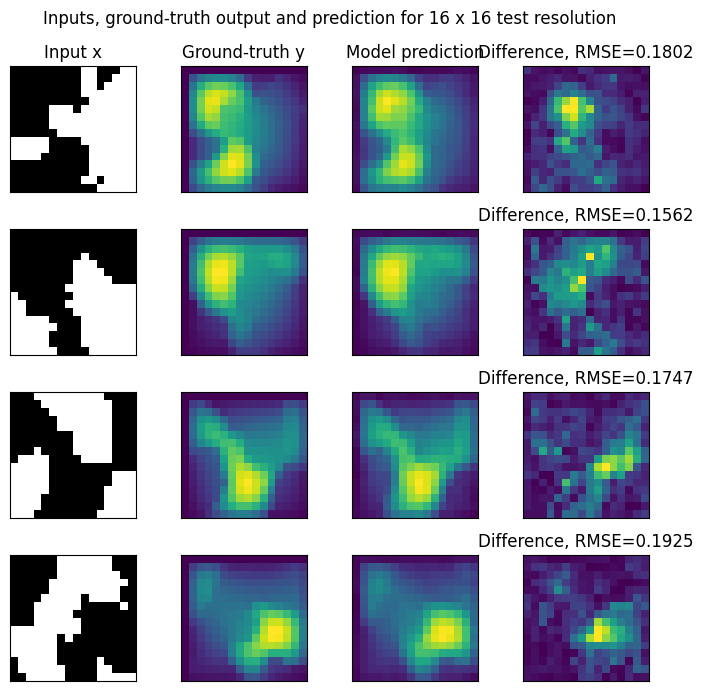

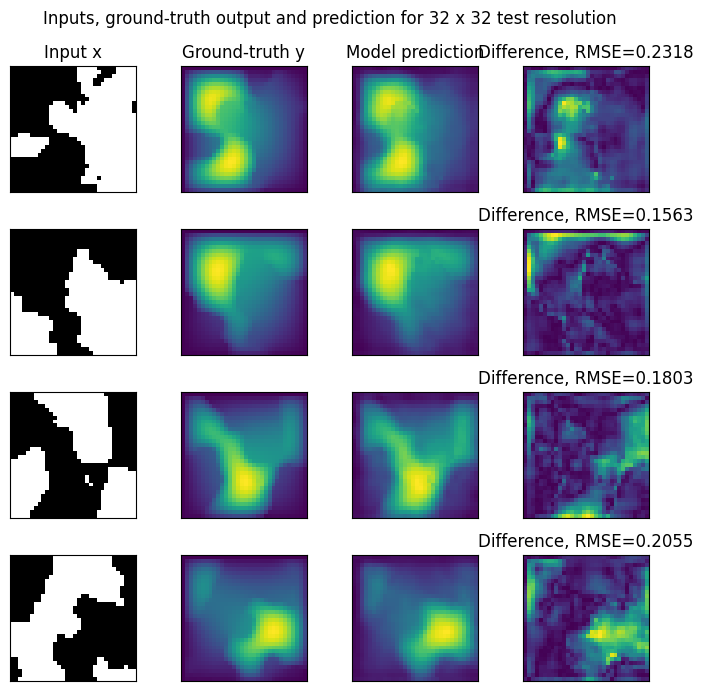

In [ ]:
print("Device used: %s"%device)

plot_training_results(test_samples_x, test_samples_y, model,\
                      'Inputs, ground-truth output and prediction for 16 x 16 test resolution')
plot_training_results(test_samples_x_32, test_samples_y_32, model,\
                      'Inputs, ground-truth output and prediction for 32 x 32 test resolution')

## Task #5 Match coresponding weights with correct frequencies

## Answer (do not peak)

In [ ]:
"""

code adapted from from: https://github.com/khassibi/fourier-neural-operator/blob/main/fourier_2d.py


@original author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Darcy Flow discussed in Section 5.2 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

################################################################
# fourier layer
################################################################
class SpectralConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = torch.nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = torch.nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes


        multiplicity = x.size(-2) // (16+9)

        if not self.training:                      #print only in evaluation mode
          print("Multiplicity = %d; image size = %d x %d"%(multiplicity, x.size(-2), x.size(-1)))

        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)

        # old code: out_ft[:, :, :self.modes1, :self.modes2] = \
          #self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)

        out_ft[:, :, :(self.modes1 * multiplicity):multiplicity, :(self.modes2 * multiplicity):multiplicity] = \
           self.compl_mul2d( x_ft[:, :, :(self.modes1 * multiplicity):multiplicity, :(self.modes2 * multiplicity):multiplicity], self.weights1)

        # old code: out_ft[:, :, -self.modes1:, :self.modes2] = \
          #self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        out_ft[:, :, -(self.modes1 * multiplicity)::multiplicity, :(self.modes2 * multiplicity):multiplicity] = \
           self.compl_mul2d( x_ft[:, :, -(self.modes1 * multiplicity)::multiplicity, :(self.modes2 * multiplicity):multiplicity], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


In [ ]:
################################################################
# initializing model and an optimizer
################################################################
model = FNO2d(modes, modes, hidden_width).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=1e-4)

In [ ]:
################################################################
# training loop
################################################################

print("Device used: %s"%device)

model.train()

for epoch in range(epochs):
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        out = model(x)

        mse = torch.nn.functional.mse_loss(out, y, reduction='mean')
        epoch_loss += mse.item()

        mse.backward()
        optimizer.step()

    print("Epoch: %d with loss %.4f"%(epoch, epoch_loss))



Device used: cpu
Epoch: 0 with loss 13.7667
Epoch: 1 with loss 3.7449
Epoch: 2 with loss 2.4555
Epoch: 3 with loss 1.7554
Epoch: 4 with loss 1.2769
Epoch: 5 with loss 1.2655
Epoch: 6 with loss 1.0096
Epoch: 7 with loss 0.7571
Epoch: 8 with loss 0.5930
Epoch: 9 with loss 0.4627
Epoch: 10 with loss 0.4115
Epoch: 11 with loss 0.3576
Epoch: 12 with loss 0.3348
Epoch: 13 with loss 0.2999
Epoch: 14 with loss 0.2770
Epoch: 15 with loss 0.2703
Epoch: 16 with loss 0.2501
Epoch: 17 with loss 0.2848
Epoch: 18 with loss 0.3135
Epoch: 19 with loss 0.2264


### Did that improve super resultion?

Device used: cpu
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 1; image size = 25 x 25
Multiplicity = 2; image size = 50 x 50
Multiplicity = 2; image size = 50 x 50
Multiplicity = 2; image size = 50 x 50
Multiplicity = 2; image size = 50 x 50
Multiplicity = 2; image size = 50 x 50
Multiplicity = 2; image size = 50 x 50
Multiplicity = 2; image size = 50 x 50
Multiplicity = 2; image size = 50 x 50
Multiplicity = 2; image size = 50 x 50
Multipli

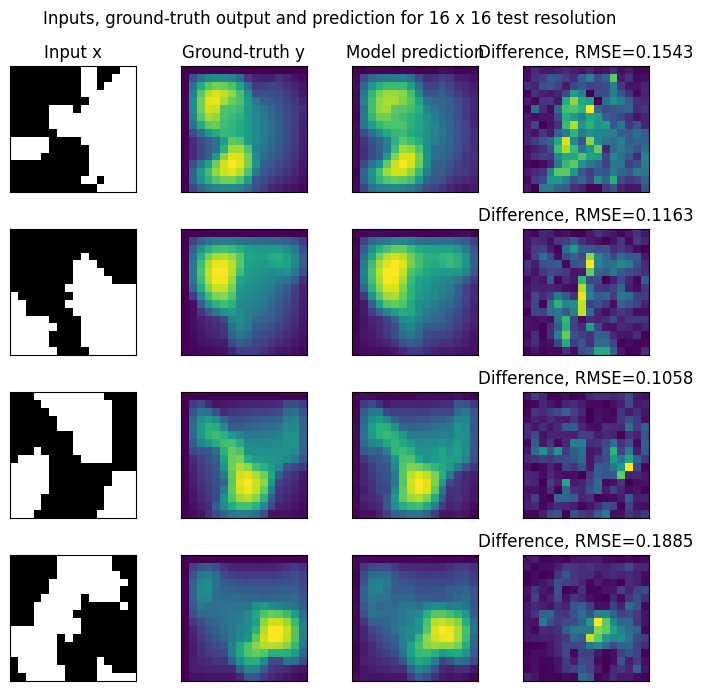

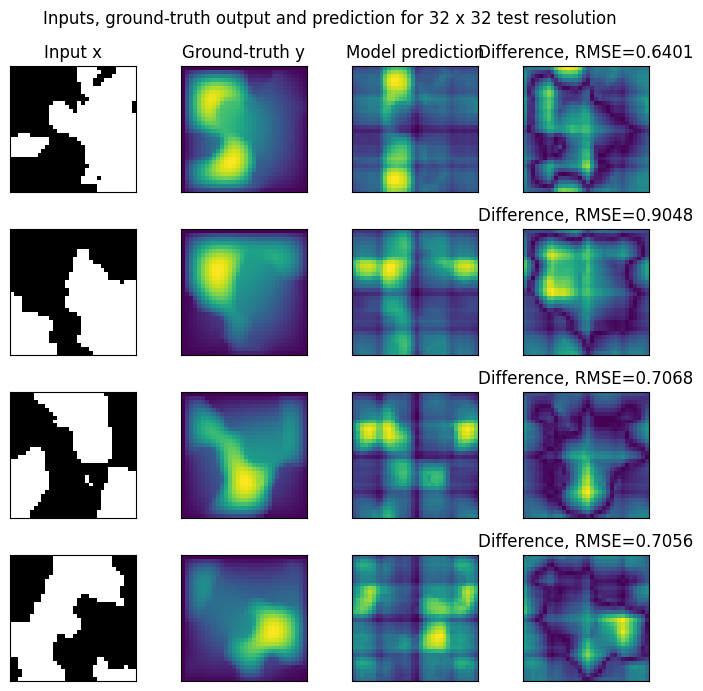

In [ ]:
print("Device used: %s"%device)

plot_training_results(test_samples_x, test_samples_y, model,\
                      'Inputs, ground-truth output and prediction for 16 x 16 test resolution')
plot_training_results(test_samples_x_32, test_samples_y_32, model,\
                      'Inputs, ground-truth output and prediction for 32 x 32 test resolution')

Well, it didn't. Recall the rectangle we took to Fourier domain and back.

Retaining 3 lowest frequencies makes it circular, no mather the initial resolution, and this is the resolution that controls the *frequency values*.

If we retained 3 lowest odd frequencies, we wouldn't get a circle, would we?

However, on the other hand, controlling for the multiplicity of the image size *was* important. Otherwise we got artifacts in the resulting image.

I must admit I don't fully understand it. I would like to leave it with this feeling that there is much more to be uncovered. I am also open to a discussion.

# Final notes

1. The FNO, in contrast to PINNs, doesn't implicitly or explicitly know the underlying PDE.
1. It can be thought off as an image to image transformation.
1. Consequently, it could also model a process undergoing *unknown* changes, provided that enough examples of initial and final states are known.
1. The FNO implementation can perform global convolutions efficiently and this is the strength allowing it to solve PDE mappings, because doing the convolution is often a part of solving the PDE if performed my the mathematician.
1. It can do super resolution provided we take care to match correctly corresponding frequencies

# Questions ?